In [6]:
import os
# --------- CONFIG --------------------------------
mainpath="/Users/DELL/datasets"
filename="VEN.csv"
FILE=os.path.join(mainpath,filename)

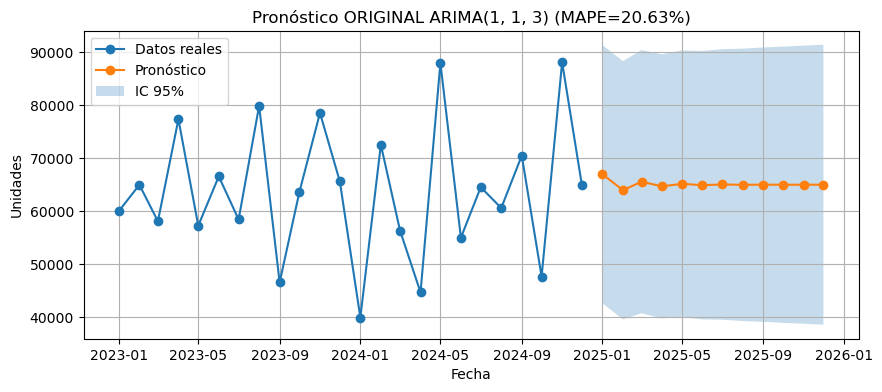

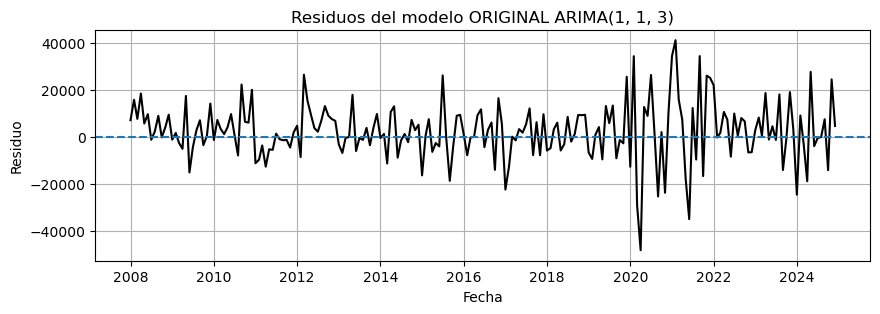

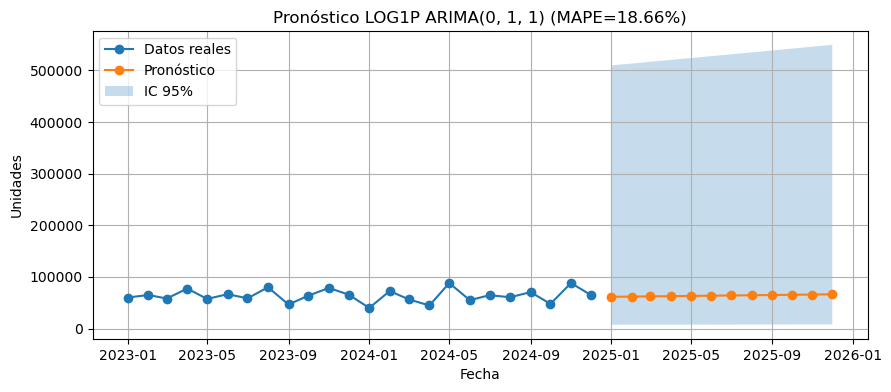

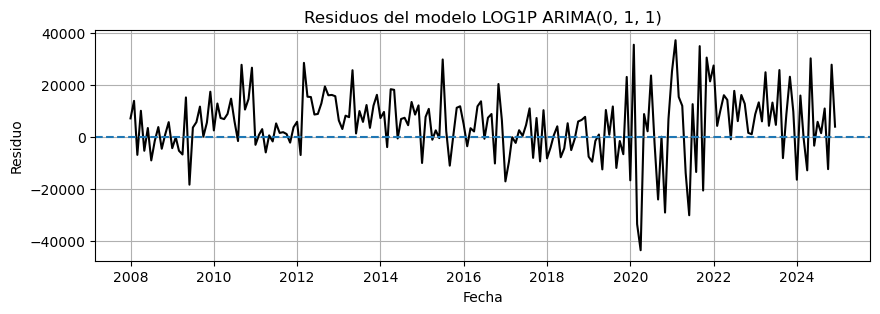


TABLA COMPARATIVA FINAL
              order trend           MAE          RMSE       MAPE        R2  \
original  (1, 1, 3)  None  12063.069736  14833.158047  20.625191 -0.005131   
log1p     (0, 1, 1)     c  11882.564609   15110.55489  18.657299 -0.043077   

         LjungBox_p Shapiro_p JarqueBera_p  
original   0.148376  0.000183          0.0  
log1p      0.038486  0.002575     0.000034  


In [7]:
# ======================================================
# ARIMA vs LOG-ARIMA – Anexo a peticion del jurado
# ======================================================

import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, jarque_bera
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# ======================================================
# CONFIGURACIÓN DE DATOS
# ======================================================
mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

# ======================================================
# FUNCIONES AUXILIARES
# ======================================================
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# ======================================================
# CARGA Y PREPARACIÓN DE DATOS
# ======================================================
df = pd.read_csv(FILE)

df["FECHA"] = pd.to_datetime(
    df["AÑO"].astype(str) + "-" + df["MES"].astype(str) + "-01"
)
df["UNIDADES"] = pd.to_numeric(df["UNIDADES"], errors="coerce")

ts = (
    df.groupby(pd.Grouper(key="FECHA", freq="MS"))["UNIDADES"]
    .sum()
    .asfreq("MS")
    .astype(float)
)

ts = ts.interpolate().ffill().bfill()

# ======================================================
# VALIDACIÓN (12 MESES)
# ======================================================
test_periods = 12
results = {}

# ======================================================
# MODELOS: ORIGINAL y LOG-ARIMA
# ======================================================
for mode in ["original", "log1p"]:

    series = ts.copy() if mode == "original" else np.log1p(ts)

    train = series.iloc[:-test_periods]
    val = series.iloc[-test_periods:]

    best_mape = np.inf
    best_model = None
    best_order = None
    best_trend = None

    for trend in ["c", None]:
        for p in range(0, 4):
            for q in range(0, 4):
                try:
                    model = SARIMAX(
                        train,
                        order=(p, 1, q),
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    )
                    res = model.fit(disp=False)

                    forecast = res.get_forecast(steps=len(val)).predicted_mean

                    if mode == "log1p":
                        forecast_bt = np.expm1(forecast)
                        val_bt = np.expm1(val)
                    else:
                        forecast_bt = forecast
                        val_bt = val

                    mape = safe_mape(val_bt, forecast_bt)

                    if mape < best_mape:
                        best_mape = mape
                        best_model = res
                        best_order = (p, 1, q)
                        best_trend = trend

                except:
                    continue

    # ======================================================
    # AJUSTE FINAL Y PRONÓSTICO
    # ======================================================
    model_full = SARIMAX(
        series,
        order=best_order,
        trend=best_trend,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res_full = model_full.fit(disp=False)

    forecast_obj = res_full.get_forecast(steps=12)
    forecast_mean = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()

    if mode == "log1p":
        forecast_bt = np.expm1(forecast_mean)
        ci_lower = np.expm1(ci.iloc[:, 0])
        ci_upper = np.expm1(ci.iloc[:, 1])
        hist = np.expm1(series)
    else:
        forecast_bt = forecast_mean
        ci_lower = ci.iloc[:, 0]
        ci_upper = ci.iloc[:, 1]
        hist = series

    # ======================================================
    # MÉTRICAS
    # ======================================================
    pred_val = best_model.get_forecast(steps=len(val)).predicted_mean

    if mode == "log1p":
        pred_val_bt = np.expm1(pred_val)
        val_bt = np.expm1(val)
    else:
        pred_val_bt = pred_val
        val_bt = val

    mae = mean_absolute_error(val_bt, pred_val_bt)
    rmse = np.sqrt(mean_squared_error(val_bt, pred_val_bt))
    mape = safe_mape(val_bt, pred_val_bt)
    r2 = r2_score(val_bt, pred_val_bt)

    # ======================================================
    # RESIDUOS (ESCALA ORIGINAL)
    # ======================================================
    fitted = res_full.fittedvalues

    if mode == "log1p":
        fitted_bt = np.expm1(fitted)
        observed_bt = np.expm1(series)
    else:
        fitted_bt = fitted
        observed_bt = series

    resid = (observed_bt - fitted_bt).dropna()

    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    sw_p = shapiro(resid)[1]
    jb_p = jarque_bera(resid)[1]

    results[mode] = {
        "order": best_order,
        "trend": best_trend,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "LjungBox_p": lb_p,
        "Shapiro_p": sw_p,
        "JarqueBera_p": jb_p,
    }

    # ======================================================
    # GRÁFICO DE PRONÓSTICO 
    # ======================================================
    hist_plot = hist.iloc[-24:]

    plt.figure(figsize=(10, 4))
    plt.plot(hist_plot.index, hist_plot, label="Datos reales", marker="o")
    plt.plot(forecast_bt.index, forecast_bt, label="Pronóstico", marker="o")
    plt.fill_between(
        forecast_bt.index, ci_lower, ci_upper, alpha=0.25, label="IC 95%"
    )
    plt.title(
        f"Pronóstico {mode.upper()} ARIMA{best_order} (MAPE={mape:.2f}%)"
    )
    plt.xlabel("Fecha")
    plt.ylabel("Unidades")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ======================================================
    # GRÁFICO DE RESIDUOS
    # ======================================================
    plt.figure(figsize=(10, 3))
    plt.plot(resid.index, resid, color="black")
    plt.axhline(0, linestyle="--")
    plt.title(f"Residuos del modelo {mode.upper()} ARIMA{best_order}")
    plt.xlabel("Fecha")
    plt.ylabel("Residuo")
    plt.grid(True)
    plt.show()


# ======================================================
# TABLA FINAL COMPARATIVA
# ======================================================
summary = pd.DataFrame(results).T.round(4)
print("\nTABLA COMPARATIVA FINAL")
print(summary)
